# Getting started with ELA

This notebook uses data covering a few kilometres around the township of [Bungendore](https://www.google.com.au/maps/@-35.251235,149.4173155,34159m/data=!3m1!1e3) in NSW, Australia. 

Data was obtained from the Australian Bureau of Meteorology [National Groundwater Information System](http://www.bom.gov.au/water/groundwater/ngis/index.shtml) and from [ELVIS - Elevation and Depth - Foundation Spatial Data](http://elevation.fsdf.org.au/). If a data subset is linked from this notebook check the data licensing. The short version is that use for learning puroses is fine. 

## Status

As of March 2019 this present document is a work in progress but enough to give a flavor of the package to interested geoscientists.


## Purpose

This notebook is a realistic example of one case study the pyela package addresses. What we obtain at the end of the workflow is a 3D gridded model of primary lithologies. A visual outcome (normally interactive) is:

![3D Interpolated overlay primary lithology clay](img/3d_overlay_bungendore_clay_lithology.png)

## Importing python packages

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd


In [2]:
# Only True for co-dev of ela from this use case:
ela_from_source = False
ela_from_source = True

In [3]:
if ela_from_source:
    if ('ELA_SRC' in os.environ):
        root_src_dir = os.environ['ELA_SRC']
    elif sys.platform == 'win32':
        root_src_dir = r'C:\src\github_jm\pyela'
    else:
        username = os.environ['USER']
        root_src_dir = os.path.join('/home', username, 'src/github_jm/pyela')
    pkg_src_dir = root_src_dir
    sys.path.append(pkg_src_dir)

from ela.textproc import *
from ela.utils import *
from ela.classification import *
from ela.visual import *

## Importing data

In [4]:
if ('ELA_DATA' in os.environ):
    data_path = os.environ['ELA_DATA']
elif sys.platform == 'win32':
    data_path = r'C:\data\Lithology'
else:
    username = os.environ['USER']
    data_path = os.path.join('/home', username, 'data')

bungendore_raster = rasterio.open(os.path.join(data_path, 'Bungendore','CLIP_66949','CLIP_reproj_UTM55.tif'))

In [5]:
raster_projstring = "+proj=utm +zone=55 +south +datum=WGS84 +units=m +no_defs"

In [6]:
bidgee_path = os.path.join(data_path, 'Bungendore/gw_shp_murrumbidgee_river/shp_murrumbidgee_river')
filename = os.path.join(data_path, 'Bungendore/gw_shp_murrumbidgee_river/shp_bungendore.shp')

In [7]:
shape=gpd.read_file(filename)

In [8]:
#shape_reproj = shape.to_crs(epsg=4283)
shape_reproj = shape.to_crs(raster_projstring)

In [9]:
shape_reproj.head()

,HydroID,HydroCode,StateBoreI,StatePipeI,StateTerri,Agency,WCode,BoreDepth,DrilledDep,Status,...,Hydrostrat,WaterLevel,Salinity,WaterCount,WaterDateM,WaterDat_1,SalinityCo,SalinityDa,Salinity_1,geometry
0,10055899,GW061345.1.1,GW061345,1.1,1,1,8,53.3,53.3,UNK,...,0,0,0,0,None,None,0,None,None,POINT (713783.3445196336 6099618.639519438)
1,10094010,GW404937.1.1,GW404937,1.1,1,1,8,96.0,96.0,ABN,...,0,0,0,0,None,None,0,None,None,POINT (718150.9998919906 6093237.005439439)
2,10114667,GW414316.1.1,GW414316,1.1,1,1,8,42.0,42.0,USE,...,0,0,0,0,None,None,0,None,None,POINT (713568.9940640795 6106887.001336511)
3,10114672,GW414581.1.1,GW414581,1.1,1,1,8,42.0,0.0,USE,...,0,0,0,0,None,None,0,None,None,POINT (715642.0000155731 6097858.004591262)
4,10122533,GW402017.1.1,GW402017,1.1,1,1,8,90.0,90.0,UNK,...,0,0,0,0,None,None,0,None,None,POINT (712620.6561813344 6102894.13739373)


### Geolocation of data

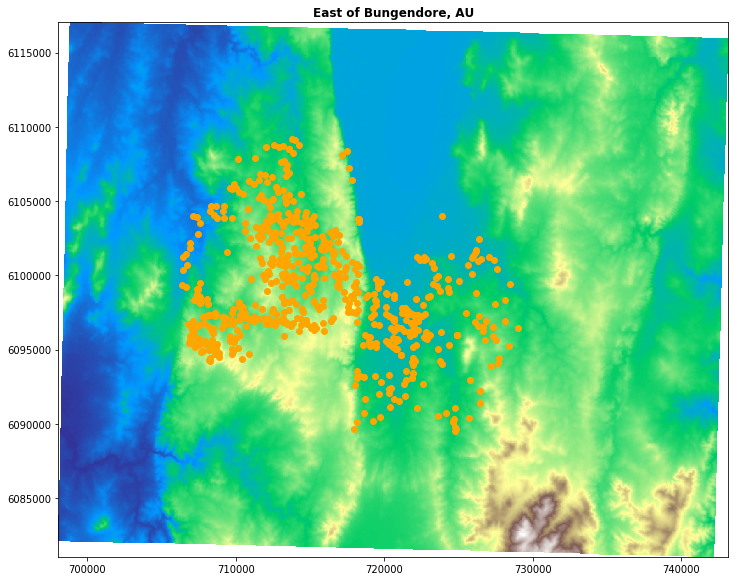

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))
show(bungendore_raster,title='East of Bungendore, AU', cmap='terrain',  ax=ax)
shape_reproj.plot(ax=ax, facecolor='orange')

In [11]:
lithology_logs = pd.read_csv(os.path.join(bidgee_path, 'NGIS_LithologyLog.csv'))

In [12]:
lithology_logs.head(n=10)

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType
0,3295968,10096490,GW403458.1.1,332.05,UNK,29.0,30.0,303.05,302.05,None,NaN,Sump,UNK,1
1,3295974,10117707,GW400023.1.1,108.41,UNK,69.0,71.0,39.41,37.41,None,NaN,NaN,UNK,1
2,3295982,10094368,GW405126.1.1,223.24,UNK,0.0,0.6,223.24,222.64,TPSL,NaN,Topsoil,UNK,1
3,3296095,10113483,GW415991.1.1,None,UNK,0.4,10.0,None,None,CLAY,NaN,Clay,UNK,1
4,3296209,10144702,GW401440.1.1,76.17,UNK,128.0,139.0,-51.83,-62.83,None,NaN,Clay,UNK,1
5,3296429,10108243,GW416031.1.1,None,UNK,1.0,4.0,None,None,CLAY,NaN,Clay,UNK,1
6,3296436,10130964,GW416560.1.1,None,UNK,5.1,7.0,None,None,FSND,NaN,"Fine sand, dry",UNK,1
7,3296437,10126252,GW415984.1.1,None,UNK,0.0,0.2,None,None,FILL,NaN,Fill,UNK,1
8,3296441,10106582,GW416266.1.1,None,UNK,1.0,5.0,None,None,CLAY,NaN,Clay,UNK,1
9,3296577,10004408,GW030348.1.1,115.9,NGS,4.58,6.1,111.32,109.8,CLAY,NaN,Clay - grey to yellow brown; quartz grains fin...,WC&IC,2


### Subset to the location of interest

The lithology logs are for all of the Murrumbidgee catchment, which is much larger than the area of interest and for which we have the geolocation of boreholes. We subset to the location of interest 

In [13]:
DEPTH_FROM_COL = 'FromDepth'
DEPTH_TO_COL = 'ToDepth'

In [14]:
TOP_ELEV_COL = 'TopElev'
BOTTOM_ELEV_COL = 'BottomElev'

In [15]:
LITHO_DESC_COL = 'Description'

In [16]:
df = lithology_logs

Curious that ~2500 data points do not have their AHD height but their depth. 

While this can be remediated, we should maybe hold off since the domain upon which we will work is small compared to the full spatial extent of the data set. So, let's subset the logs based on spatial locations, to keep only those "nearby" the DEM we have near the locality of Bungendore in this case study.

In [17]:
df.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType
0,3295968,10096490,GW403458.1.1,332.05,UNK,29.0,30.0,303.05,302.05,None,NaN,Sump,UNK,1
1,3295974,10117707,GW400023.1.1,108.41,UNK,69.0,71.0,39.41,37.41,None,NaN,NaN,UNK,1
2,3295982,10094368,GW405126.1.1,223.24,UNK,0.0,0.6,223.24,222.64,TPSL,NaN,Topsoil,UNK,1
3,3296095,10113483,GW415991.1.1,None,UNK,0.4,10.0,None,None,CLAY,NaN,Clay,UNK,1
4,3296209,10144702,GW401440.1.1,76.17,UNK,128.0,139.0,-51.83,-62.83,None,NaN,Clay,UNK,1


### Merging the geolocation from the shapefile and lithology records

In [18]:
geoloc = get_coords_from_gpd_shape(shape_reproj)
geoloc["HydroCode"] = shape_reproj["HydroCode"]
geoloc.head()

,x,y,HydroCode
0,713783.344520,6.099619e+06,GW061345.1.1
1,718150.999892,6.093237e+06,GW404937.1.1
2,713568.994064,6.106887e+06,GW414316.1.1
3,715642.000016,6.097858e+06,GW414581.1.1
4,712620.656181,6.102894e+06,GW402017.1.1


In [19]:
len(geoloc), len(df)

(640, 58944)

In [20]:
df = pd.merge(df, geoloc, how='inner', on="HydroCode", sort=False, copy=True, indicator=False, validate=None)

In [21]:
len(df)

2454

In [22]:
df.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType,x,y
0,3297041,10037380,GW058949.1.1,691.43,UNK,8.8,11.0,682.63,680.43,SHLE,NaN,Shale broken,UNK,1,720769.160247,6.095597e+06
1,3297109,10037380,GW058949.1.1,691.43,UNK,0.0,0.9,691.43,690.53,TPSL,NaN,Topsoil,UNK,1,720769.160247,6.095597e+06
2,3297126,10037380,GW058949.1.1,691.43,UNK,0.9,3.3,690.53,688.13,CLAY,NaN,Clay,UNK,1,720769.160247,6.095597e+06
3,3297127,10037380,GW058949.1.1,691.43,UNK,5.2,7.3,686.23,684.13,SAND,NaN,Sand clay,UNK,1,720769.160247,6.095597e+06
4,3297180,10037380,GW058949.1.1,691.43,UNK,7.3,8.8,684.13,682.63,CLAY,NaN,Clay,UNK,1,720769.160247,6.095597e+06


We will duplicate the x and y columns to use column identifiers easting and northing. TODO: refactor the package to map different column names.

In [23]:
df[EASTING_COL] = df['x']
df[NORTHING_COL] = df['y']

In [24]:
df.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType,x,y,Easting,Northing
0,3297041,10037380,GW058949.1.1,691.43,UNK,8.8,11.0,682.63,680.43,SHLE,NaN,Shale broken,UNK,1,720769.160247,6.095597e+06,720769.160247,6.095597e+06
1,3297109,10037380,GW058949.1.1,691.43,UNK,0.0,0.9,691.43,690.53,TPSL,NaN,Topsoil,UNK,1,720769.160247,6.095597e+06,720769.160247,6.095597e+06
2,3297126,10037380,GW058949.1.1,691.43,UNK,0.9,3.3,690.53,688.13,CLAY,NaN,Clay,UNK,1,720769.160247,6.095597e+06,720769.160247,6.095597e+06
3,3297127,10037380,GW058949.1.1,691.43,UNK,5.2,7.3,686.23,684.13,SAND,NaN,Sand clay,UNK,1,720769.160247,6.095597e+06,720769.160247,6.095597e+06
4,3297180,10037380,GW058949.1.1,691.43,UNK,7.3,8.8,684.13,682.63,CLAY,NaN,Clay,UNK,1,720769.160247,6.095597e+06,720769.160247,6.095597e+06


### Round up 'depth to' and 'depth from' columns

We round the depth related columns to the upper integer value and drop the entries where the resulting depths have degenerated to 0. We first clean up height/depths columns to make sure they are numeric.


In [25]:
def as_numeric(x):
    if isinstance(x, float):
        return x
    if x == 'None':
        return np.nan
    elif x is None:
        return np.nan
    elif isinstance(x, str):
        return float(x)
    else:
        return float(x)

In [26]:
df[DEPTH_FROM_COL] = df[DEPTH_FROM_COL].apply(as_numeric)
df[DEPTH_TO_COL] = df[DEPTH_TO_COL].apply(as_numeric)
df[TOP_ELEV_COL] = df[TOP_ELEV_COL].apply(as_numeric)
df[BOTTOM_ELEV_COL] = df[BOTTOM_ELEV_COL].apply(as_numeric)

In [27]:
dr = DepthsRounding(DEPTH_FROM_COL, DEPTH_TO_COL)

In [28]:
"Before rounding heights we have " + str(len(df)) + " records"

'Before rounding heights we have 2454 records'

In [29]:
df = dr.round_to_metre_depths(df, np.round, True)
"After removing thin sliced entries of less than a metre, we are left with " + str(len(df)) + " records left"

'After removing thin sliced entries of less than a metre, we are left with 2222 records left'

## Exploring the descriptive lithology 

In [30]:
descs = df[LITHO_DESC_COL]
descs = descs.reset_index()
descs = descs[LITHO_DESC_COL]
descs.head()

0    Shale broken
1         Topsoil
2            Clay
3       Sand clay
4            Clay
Name: Description, dtype: object

The description column as read seems to be objects. Other columns seem to be objects when they should be numeric. We define two functions to clean these.

In [31]:
def clean_desc(x):
    if isinstance(x, float):
        return u''
    elif x is None:
        return u''
    else:
        # python2 return unicode(x)        
        return x

In [32]:
y = [clean_desc(x) for x in descs]

In [33]:
from striplog import Lexicon
lex = Lexicon.default()

In [34]:
y = clean_lithology_descriptions(y, lex)

We get a flat list of all the "tokens" but remove stop words ('s', 'the' and the like)

In [35]:
y = v_lower(y)
vt = v_word_tokenize(y)
flat = np.concatenate(vt)

In [36]:
import nltk
from nltk.corpus import stopwords

In [37]:
stoplist = stopwords.words('english')
exclude = stoplist + ['.',',',';',':','(',')','-']
flat = [word for word in flat if word not in exclude]

In [38]:
len(set(flat))

301

In [39]:
df_most_common= token_freq(flat, 50)

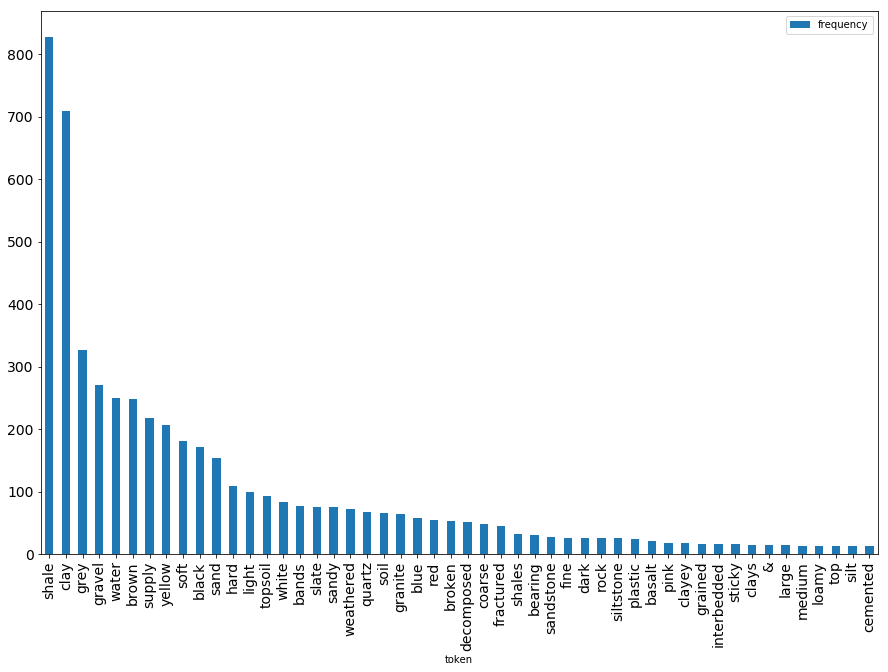

In [40]:
plot_freq(df_most_common)

There are terms such as 'sandy', 'clayey', 'silty' and so on. Let's define functions to detect terms derived from lithology classes, and their frequency. Given the likely skewness, we use a y log scale. 

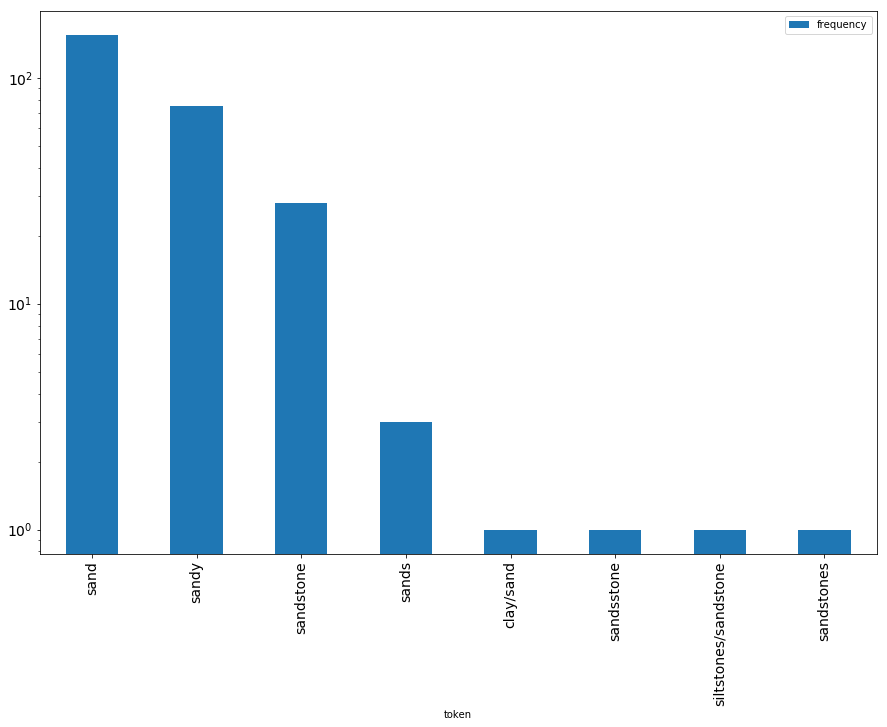

In [41]:
plot_freq_for_root(flat, 'sand')

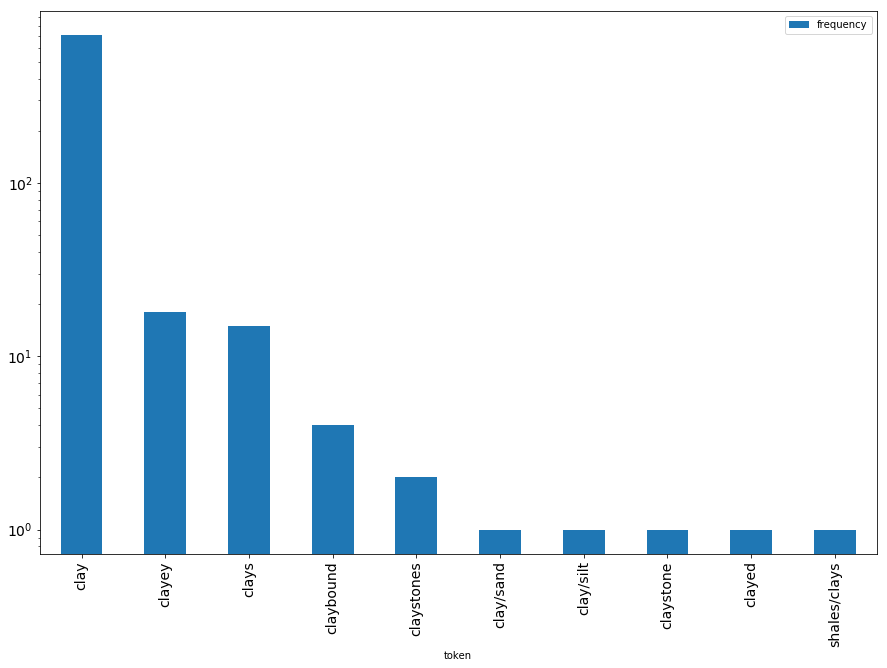

In [42]:
plot_freq_for_root(flat, 'clay')

In [43]:
# TODO: add a section that defines additional clean up e.g. 'sand/clay/soil' or dashed union composite terms
# split_composite_term('sand/clay/soil', '/').replace('/', ' / ')

In [44]:
df_most_common

,token,frequency
0,shale,828
1,clay,709
2,grey,327
3,gravel,270
4,water,250
5,brown,248
6,supply,218
7,yellow,206
8,soft,182
9,black,172


## Defining lithology classes and finding primary/secondary lithologies

From the list of most common tokens, we may want to define lithology classes as follows:

In [45]:
df[LITHO_DESC_COL] = y

In [46]:
lithologies = ['clay','sand','gravel','granite','shale','silt','topsoil','loam','soil','slate','sandstone']

And to capture any of these we devise a regular expression:

In [47]:
any_litho_markers_re = r'sand|clay|ston|shale|silt|granit|soil|gravel|loam|slate'
regex = re.compile(any_litho_markers_re)

In [48]:
my_lithologies_numclasses = create_numeric_classes(lithologies)

In [49]:
lithologies_dict = dict([(x,x) for x in lithologies])
lithologies_dict['sands'] = 'sand'
lithologies_dict['clays'] = 'clay'
lithologies_dict['shales'] = 'shale'
lithologies_dict['claystone'] = 'clay'
lithologies_dict['siltstone'] = 'silt'
lithologies_dict['limesand'] = 'sand' # ??
lithologies_dict['calcarenite'] = 'limestone' # ??
lithologies_dict['calcitareous'] = 'limestone' # ??
lithologies_dict['mudstone'] = 'silt' # ??
lithologies_dict['capstone'] = 'limestone' # ??
lithologies_dict['ironstone'] = 'sandstone' # ??
#lithologies_dict['topsoil'] = 'soil' # ??

In [50]:
lithologies_adjective_dict = {
    'sandy' :  'sand',
    'clayey' :  'clay',
    'clayish' :  'clay',
    'shaley' :  'shale',
    'silty' :  'silt',
    'gravelly' :  'gravel'
}

In [51]:
v_tokens = v_word_tokenize(y)
litho_terms_detected = v_find_litho_markers(v_tokens, regex=regex)

Let's see if we detect these lithology markers in each bore log entries  

In [52]:
zero_mark = [x for x in litho_terms_detected if len(x) == 0 ]
at_least_one_mark = [x for x in litho_terms_detected if len(x) >= 1]
at_least_two_mark = [x for x in litho_terms_detected if len(x) >= 2]
print('There are %s entries with no marker, %s entries with at least one, %s with at least two'%(len(zero_mark),len(at_least_one_mark),len(at_least_two_mark)))

There are 148 entries with no marker, 2074 entries with at least one, 446 with at least two


Note: probably need to think of precanned facilities in ela to assess the detection rate in such EDA. Maybe wordcloud not such a bad idea too.

In [53]:
descs_zero_mark = [y[i] for i in range(len(litho_terms_detected)) if len(litho_terms_detected[i]) == 0 ]

In [54]:
descs_zero_mark[1:20]

['quartz water supply',
 'humus',
 'quartz',
 'aquifer water supply',
 'none',
 'none',
 'black rock',
 'rock water supply',
 'yellow rock',
 'basalt',
 'coal lignitic',
 'driller',
 'dacite water supply',
 'surface rock',
 'dacite, yellowibrown',
 'dacite, blue/black',
 'quartz feldspar porphry - quartz veins',
 'sediment, light browns-white',
 'sediment - fine']

In [55]:
primary_litho = v_find_primary_lithology(litho_terms_detected, lithologies_dict)

In [56]:
secondary_litho = v_find_secondary_lithology(litho_terms_detected, primary_litho, lithologies_adjective_dict, lithologies_dict)

In [57]:
df[PRIMARY_LITHO_COL]=primary_litho
df[SECONDARY_LITHO_COL]=secondary_litho

In [58]:
df[PRIMARY_LITHO_NUM_COL] = v_to_litho_class_num(primary_litho, my_lithologies_numclasses)
df[SECONDARY_LITHO_NUM_COL] = v_to_litho_class_num(secondary_litho, my_lithologies_numclasses)

In [59]:
df.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,...,Source,LogType,x,y,Easting,Northing,Lithology_1,Lithology_2,Lithology_1_num,Lithology_2_num
0,3297041,10037380,GW058949.1.1,691.43,UNK,9.0,11.0,682.63,680.43,SHLE,...,UNK,1,720769.160247,6.095597e+06,720769.160247,6.095597e+06,shale,,4.0,NaN
1,3297109,10037380,GW058949.1.1,691.43,UNK,0.0,1.0,691.43,690.53,TPSL,...,UNK,1,720769.160247,6.095597e+06,720769.160247,6.095597e+06,topsoil,,6.0,NaN
2,3297126,10037380,GW058949.1.1,691.43,UNK,1.0,3.0,690.53,688.13,CLAY,...,UNK,1,720769.160247,6.095597e+06,720769.160247,6.095597e+06,clay,,0.0,NaN
3,3297127,10037380,GW058949.1.1,691.43,UNK,5.0,7.0,686.23,684.13,SAND,...,UNK,1,720769.160247,6.095597e+06,720769.160247,6.095597e+06,sand,clay,1.0,0.0
4,3297180,10037380,GW058949.1.1,691.43,UNK,7.0,9.0,684.13,682.63,CLAY,...,UNK,1,720769.160247,6.095597e+06,720769.160247,6.095597e+06,clay,,0.0,NaN


## Converting depth below ground to Australian Height Datum elevation

While the bore entries have columns for AHD elevations, many appear to be missing data. Since we have a DEM of the region we can correct this.

In [60]:
cd = HeightDatumConverter(bungendore_raster)

In [61]:
df = cd.add_height(df, 
        depth_from_col=DEPTH_FROM_COL, depth_to_col=DEPTH_TO_COL, 
        depth_from_ahd_col=DEPTH_FROM_AHD_COL, depth_to_ahd_col=DEPTH_TO_AHD_COL, 
        easting_col="x", northing_col="y", drop_na=False)

In [62]:
df.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,...,x,y,Easting,Northing,Lithology_1,Lithology_2,Lithology_1_num,Lithology_2_num,Depth From (AHD),Depth To (AHD)
0,3297041,10037380,GW058949.1.1,691.43,UNK,9.0,11.0,682.63,680.43,SHLE,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,shale,,4.0,NaN,682.26709,680.26709
1,3297109,10037380,GW058949.1.1,691.43,UNK,0.0,1.0,691.43,690.53,TPSL,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,topsoil,,6.0,NaN,691.26709,690.26709
2,3297126,10037380,GW058949.1.1,691.43,UNK,1.0,3.0,690.53,688.13,CLAY,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,clay,,0.0,NaN,690.26709,688.26709
3,3297127,10037380,GW058949.1.1,691.43,UNK,5.0,7.0,686.23,684.13,SAND,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,sand,clay,1.0,0.0,686.26709,684.26709
4,3297180,10037380,GW058949.1.1,691.43,UNK,7.0,9.0,684.13,682.63,CLAY,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,clay,,0.0,NaN,684.26709,682.26709


In [63]:
# to be reused in experimental notebooks:
classified_logs_filename = os.path.join(data_path, 'Bungendore','classified_logs.pkl')
df.to_pickle(classified_logs_filename)


## Interpolate over a regular grid


In [64]:
# max/min bounds
shp_bbox = get_bbox(shape_reproj)
shp_bbox

(706394.2929625575, 6089546.817226024, 729010.1694019751, 6109176.439475171)

In [65]:
raster_bbox = bungendore_raster.bounds
raster_bbox

BoundingBox(left=698072.3317566791, bottom=6081052.435896559, right=743160.9813157511, top=6117034.783610981)

In [66]:
x_min = max(shp_bbox[0], raster_bbox[0])
x_max = min(shp_bbox[2], raster_bbox[2])
y_min = max(shp_bbox[1], raster_bbox[1])
y_max = min(shp_bbox[3], raster_bbox[3])


In [67]:
grid_res = 150
m = create_meshgrid_cartesian(x_min, x_max, y_min, y_max, grid_res)

In [68]:
[x.shape for x in m]

[(151, 131), (151, 131)]

In [69]:
dem_array = surface_array(bungendore_raster, x_min, y_min, x_max, y_max, grid_res)

In [70]:
dem_array.shape

(151, 131)

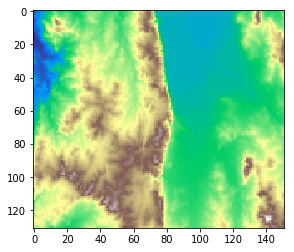

In [71]:
plt.imshow(to_carto(dem_array), cmap='terrain')

In [72]:
dem_array_data = {'bounds': (x_min, x_max, y_min, y_max), 'grid_res': grid_res, 'mesh_xy': m, 'dem_array': dem_array}

In [73]:
df.head(10)

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,...,x,y,Easting,Northing,Lithology_1,Lithology_2,Lithology_1_num,Lithology_2_num,Depth From (AHD),Depth To (AHD)
0,3297041,10037380,GW058949.1.1,691.43,UNK,9.0,11.0,682.63,680.43,SHLE,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,shale,,4.0,NaN,682.267090,680.267090
1,3297109,10037380,GW058949.1.1,691.43,UNK,0.0,1.0,691.43,690.53,TPSL,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,topsoil,,6.0,NaN,691.267090,690.267090
2,3297126,10037380,GW058949.1.1,691.43,UNK,1.0,3.0,690.53,688.13,CLAY,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,clay,,0.0,NaN,690.267090,688.267090
3,3297127,10037380,GW058949.1.1,691.43,UNK,5.0,7.0,686.23,684.13,SAND,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,sand,clay,1.0,0.0,686.267090,684.267090
4,3297180,10037380,GW058949.1.1,691.43,UNK,7.0,9.0,684.13,682.63,CLAY,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,clay,,0.0,NaN,684.267090,682.267090
5,3302117,10037380,GW058949.1.1,691.43,UNK,11.0,39.0,680.43,652.73,CLAY,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,clay,shale,0.0,4.0,680.267090,652.267090
6,3302166,10037380,GW058949.1.1,691.43,UNK,39.0,56.0,652.73,635.43,SAND,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,sand,,1.0,NaN,652.267090,635.267090
7,3302167,10037380,GW058949.1.1,691.43,UNK,56.0,57.0,635.43,634.43,CLAY,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,clay,shale,0.0,4.0,635.267090,634.267090
8,3302256,10037380,GW058949.1.1,691.43,UNK,3.0,5.0,688.13,686.23,SHLE,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,shale,,4.0,NaN,688.267090,686.267090
9,3297085,10027294,GW058023.1.1,804.98,UNK,1.0,18.0,803.98,786.98,SLTE,...,716921.554268,6.100716e+06,716921.554268,6.100716e+06,slate,,9.0,NaN,807.349976,790.349976


We need to define min and max heights on the Z axis for which we interoplate. We use the KNN algorithm with 10 neighbours. We should use a domain such that there are enough points for each height. Let's find visually heights with at least 10 records

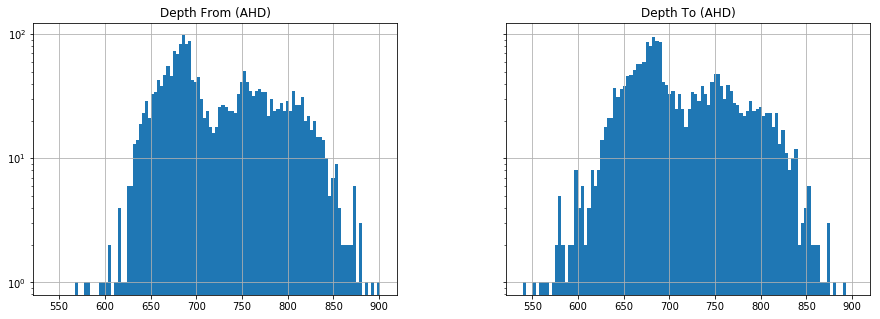

In [74]:
n_bins=100
p = df.hist(column=[DEPTH_FROM_AHD_COL,DEPTH_TO_AHD_COL], sharex=True, sharey=True, bins=n_bins, figsize=(15,5))
for axes in p:
    axes[0].set_yscale("log", nonposy='clip')

In [75]:
n_neighbours=10
ahd_min=620
ahd_max=830

z_ahd_coords = np.arange(ahd_min,ahd_max,1)
dim_x,dim_y = m[0].shape
dim_z = len(z_ahd_coords)
dims = (dim_x,dim_y,dim_z)

In [76]:
lithology_3d_array=np.empty(dims)

In [77]:
gi = GridInterpolation(easting_col='x', northing_col='y')

In [78]:
gi.interpolate_volume(lithology_3d_array, df, PRIMARY_LITHO_NUM_COL, z_ahd_coords, n_neighbours, m)

In [79]:
# Burn DEM into grid
z_index_for_ahd = z_index_for_ahd_functor(b=-ahd_min)
# check that we get the expected indexes for an AHD height
z_index_for_ahd(800), z_index_for_ahd(+630)

(180, 10)

In [80]:
dem_array.shape, m[0].shape, lithology_3d_array.shape

((151, 131), (151, 131), (151, 131, 210))

In [81]:
burn_volume(lithology_3d_array, dem_array, z_index_for_ahd, below=False)

## 2D visualisations

In [82]:
#lithologies =           ['clay',  'sand',      'gravel',    'granite', 'shale',  'silt',           'topsoil',      'loam',     'soil',    'slate',      'sandstone']
lithology_color_names = ['olive', 'yellow', 'lightgrey',      'dimgray', 'teal',  'cornsilk',     'saddlebrown', 'rosybrown', 'chocolate', 'lightslategrey', 'gold']

In [83]:
lithology_cmap = discrete_classes_colormap(lithology_color_names) # Later for exporting to RGB geotiffs??
litho_legend_display_info = [(lithology_cmap[i], lithologies[i], lithology_color_names[i]) for i in range(len(lithologies))]

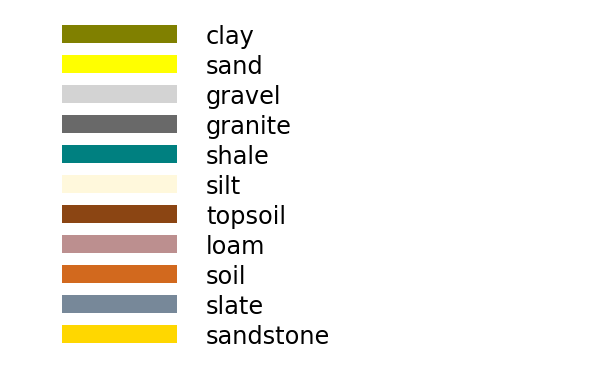

In [84]:
litho_legend = legend_fig(litho_legend_display_info)

In [85]:
cms = cartopy_color_settings(lithology_color_names)

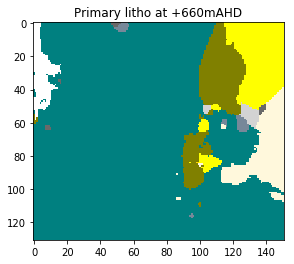

In [86]:
imgplot = plt.imshow(to_carto(lithology_3d_array[:, :, z_index_for_ahd(660)]), cmap=cms['cmap'])
title = plt.title('Primary litho at +660mAHD')

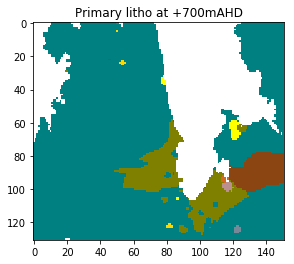

In [87]:
imgplot = plt.imshow(to_carto(lithology_3d_array[:, :, z_index_for_ahd(700)]), cmap=cms['cmap'])
title = plt.title('Primary litho at +700mAHD')

## 3D vis

In [88]:
from ela.visual3d import *

In [89]:
xx, yy = dem_array_data['mesh_xy']

In [90]:
from mayavi import mlab

In [91]:
#mlab.figure(size=(800, 800))
#mlab.surf(xx, yy, dem_array, warp_scale=20, colormap='terrain')
#mlab.outline()
#mlab.show()

In [92]:
vis_litho = LithologiesClassesVisual3d(lithologies, lithology_color_names, 'black')

In [93]:
#vis_litho.render_classes_planar(lithology_3d_array, 'Primary lithology')

In [94]:
lithology_3d_array.shape

(151, 131, 210)

In [95]:
# vis_litho.render_class(lithology_3d_array, 0)

In [96]:
df_1 = df.fillna({PRIMARY_LITHO_NUM_COL: -1.0})
df_1.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,...,x,y,Easting,Northing,Lithology_1,Lithology_2,Lithology_1_num,Lithology_2_num,Depth From (AHD),Depth To (AHD)
0,3297041,10037380,GW058949.1.1,691.43,UNK,9.0,11.0,682.63,680.43,SHLE,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,shale,,4.0,NaN,682.26709,680.26709
1,3297109,10037380,GW058949.1.1,691.43,UNK,0.0,1.0,691.43,690.53,TPSL,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,topsoil,,6.0,NaN,691.26709,690.26709
2,3297126,10037380,GW058949.1.1,691.43,UNK,1.0,3.0,690.53,688.13,CLAY,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,clay,,0.0,NaN,690.26709,688.26709
3,3297127,10037380,GW058949.1.1,691.43,UNK,5.0,7.0,686.23,684.13,SAND,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,sand,clay,1.0,0.0,686.26709,684.26709
4,3297180,10037380,GW058949.1.1,691.43,UNK,7.0,9.0,684.13,682.63,CLAY,...,720769.160247,6.095597e+06,720769.160247,6.095597e+06,clay,,0.0,NaN,684.26709,682.26709


In [97]:
df_2 = df_1[(df_1[DEPTH_TO_AHD_COL] > (ahd_min-20))]
len(df_2)

2194

In [98]:
# The factor to apply to Z coordinates, otherwise things would be squashed visually. 
# Would prefer a visual only scaling factor, but could not find a way to do so. 
Z_SCALING = 20.0

In [99]:
z_coords = np.arange(ahd_min,ahd_max,1)

In [100]:
overlay_vis_litho = LithologiesClassesOverlayVisual3d(lithologies, lithology_color_names, 'black', dem_array_data, z_coords, Z_SCALING, df_2, PRIMARY_LITHO_NUM_COL)

In [101]:
def view_class(value):
    f = overlay_vis_litho.view_overlay(value, lithology_3d_array)
    return f

In [102]:
# f = view_class(0.0)

![3D Interpolated overlay primary lithology clay](img/3d_overlay_bungendore_clay_lithology.png)

In [103]:
#f = view_class(1.0)

## Slicing and exporting as Geotiff

TODO


In [104]:
sops = SliceOperation(dem_array, z_index_for_ahd)

## Appendix trial stuff

As expected frustrating to do something simple like an overlay in Python (yearning for R's ggmap). Google with keywords "overlay a rasterio with geopandas points".
For future reference perhaps https://geohackweek.github.io/vector/06-geopandas-advanced/  . 

https://gis.stackexchange.com/questions/294072/how-can-i-superimpose-a-geopandas-dataframe-on-a-raster-plot

We extract a portion of the dem over the bounding box of the groundwater areas of interest, and save DEM data as numpy arrays that will be more convenient to work with in mayavi (with x=easting and y=northing) 

In [105]:
import pyvista
import PVGeo


In [106]:
# This sets the plotting theme of `vtki` to look just like a ParaView rendering
#vtki.set_plot_theme('paraview')
#vtki.rcParams['cmap'] = 'bwr_r'